# Model Template for amliNet :)

In [0]:
import os
import numpy as np
import pandas as pd
import math
import gc


import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import itertools
from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -q '/content/drive/My Drive/The Cool Kids/Data/CheXpert-v1.0-small.zip' 

## Global Variables

In [32]:
outcomes = ['No Finding',
            'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']
pathologies = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

#Edit these global variables
PATH = 'CheXpert-v1.0-small'
target = 'Lung Opacity'

image_size = 256
train_batch_size = 32
val_batch_size = 32
test_batch_size = 234

train_set_size = 100000
validation_percent = 0.1

lr = 0.0001 #learning rate
num_steps_per_epoch = 200 #can be set to none for auto choosing (does not work for multimodel)
num_epochs = 30

threshold = 0.5

#create the directory before you start!
model_name = 'multimodel_lungopacity'
model_directory = 'multimodeltest1/' #model_name+'/' 
if os.path.isdir(model_directory):
  print('Did you mean to rename the model?')
  if not os.path.isdir(model_directory+'checkpoints/'):
    os.makedirs(model_directory+'checkpoints/')
else:
  os.makedirs(model_directory)
  os.makedirs(model_directory+'checkpoints/')

Did you mean to rename the model?


### Save the hyperparameters used

In [33]:
hyper_df = pd.DataFrame()
hyper_df['Target'] = [target]
hyper_df['Image size'] = [image_size]
hyper_df['Training batch size'] = [train_batch_size]
hyper_df['Validation batch size'] = [val_batch_size]
hyper_df['Testing batch size'] = [test_batch_size]
hyper_df['Training Size'] = [train_set_size]
hyper_df['Validation Percent'] = [validation_percent]
hyper_df['Learning Rate'] = [lr]
hyper_df['Steps per epoch'] = [num_steps_per_epoch]
hyper_df['Number of epochs'] = [num_epochs]
hyper_df['Threshold'] = [threshold]

hyper_df.index=[model_name]
t = hyper_df.transpose()
display(t)
t.to_csv(model_directory+model_name+'hyperparameters.csv')

,multimodel_lungopacity
Target,Lung Opacity
Image size,256
Training batch size,32
Validation batch size,32
Testing batch size,234
Training Size,100000
Validation Percent,0.1
Learning Rate,0.0001
Steps per epoch,200
Number of epochs,30


## Preprocessing

In [0]:
def edit_urls(url):
  ''' a function to edit the urls to the correct path using a global PATH variable declared earlier
  '''
  pieces = url.split('/')
  newurl = ''

    #removing the previous path 'CheXpert-v1.0-small' and including the PATH
  for i, piece in enumerate(pieces):
    if i > 0:
      newurl+= '/' + piece
    elif i == 0:
      newurl += PATH

  return newurl

def clean_data(df):
  '''
  Edits the urls, fills the 'maybes' with yes and the nulls with no,
  removes outlier ages (age 0 patients), removes 'unknown gender' patients,
  collects which type of image it is
  '''
  df['Path'] = df['Path'].apply(edit_urls)
  df[outcomes] = df[outcomes].fillna(0)
  df[outcomes] = df[outcomes].replace(-1,1)
  df = df[df['Age'] > 1]
  df = df[(df['Sex'] == 'Male') | (df['Sex'] == 'Female')]
  df['Image Type'] = df['AP/PA'].fillna('Lateral')
  return df

def stratify_training_set(df):
  '''
  Groups by the target so the training set has equal amounts of 'yes target' and 'no target'
  '''
  notarg = df[ df[target] == 0 ]
  yestarg = df[ df[target] == 1]
  print(f'There are {len(yestarg)} patients with {target}, compared to {len(notarg)} patients in the dataset without {target}')
  print(f'{100* len(yestarg) / len(df)}% of patients have {target}')
  if len(notarg) > len(yestarg):
    print(f'{(len(notarg) - len(yestarg))} ({100*(len(notarg) - len(yestarg))/len(notarg)}%) of patients without {target} will be randomly removed from the sample pool')
    notarg = notarg.sample(len(yestarg))
  else:
    print(f'{(len(yestarg) - len(notarg))} ({100*(len(yestarg) - len(notarg))/len(yestarg)}%)  of patients with {target} will be randomly removed from the sample pool')
    yestarg = yestarg.sample(len(notarg))
      
  traindf = pd.concat([yestarg, notarg], axis=0)
  traindf = traindf.sample(frac=1)
  
  return traindf


In [0]:
def get_train_df(stratify = True):
  '''
  Returns the training dataframe, which has already been edited for 
  '''
  train_df = clean_data( pd.read_csv(PATH + '/train.csv') )
  
  if stratify:
    #stratify the training set by the target
    train_df = stratify_training_set(train_df)

  #can chose a subset here
  if len(train_df) > train_set_size:
    train_df = train_df.sample(train_set_size)

  #for keras, make the target a string
  train_df[target] = train_df[target].apply(str)
  
  print('training set:', train_df.shape)
  display(train_df.head(3))
  
  return train_df
  
  
def get_test_df():
  test_df = clean_data( pd.read_csv(PATH + '/valid.csv'))
  test_df[target] = test_df[target].apply(str)
  print('test set:', test_df.shape)
  return test_df
  


## Prepare the Model

### without non-image features

In [0]:
datagen = ImageDataGenerator(
   rescale = 1./255,
   validation_split = validation_percent
)

train_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=target,
   color_mode='grayscale', # images will be converted to have 1 color channel
   target_size=(image_size, image_size), #The dimensions to which all images found will be resized
   class_mode='binary', # Mode for yielding the targets 1D numpy array of binary labels,if class_mode is "binary" it must include the given y_col column with class values as strings.
   batch_size=train_batch_size,
   subset = "training"
   #shuffle: whether to shuffle the data (default: True)
)

validation_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=target,
   target_size=(image_size, image_size),
   color_mode='grayscale',
   class_mode='binary',
   batch_size=val_batch_size,
   subset = "validation"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col=target,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=test_batch_size,
    shuffle = False #just in case
)

Found 9000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 234 validated image filenames belonging to 2 classes.


## Edit your model here

### Model Preprocessing

In [0]:
def bunch_nonimage_features(df, colheaders, batch_size):
    '''
    Creates a batch with (hopefully) the same batches as the 
    train_generator, to hold nonimage features from the dataframe

    The desired shape will be:
    array - shape numbatches
    array[0] - the number of columns of data
    array[0][0] - data for the first column (one piece of data for each member of the batch)
    so the shape would be:
    (numbatches, numfeatures, batch_size)

    Because this is a numpy array, all features must be numeric.
    '''

    for feat in colheaders:
        assert df[feat].dtype in ['int', 'int8', 'int64'], f'Features must be numeric. {feat} is type {df[feat].dtype}'

    #use ceiling because we need extras
    numbatches = math.ceil(len(df) / batch_size)
    numfeatures = len(colheaders)

    #making an empty array to fill in with the information of the batches
    feats_generator = np.zeros( (numbatches, numfeatures, batch_size) )

    #using a for loop but I wonder if there's a way to do it better?
    for i in range(numbatches):
        startindex = i * batch_size

        #if the data doesn't fit evenly into the bunches, manually insert it
        if startindex + batch_size > len(df):
            numleftover = startindex + batch_size - len(df) - 1
            for counter, feat in enumerate(colheaders):
                for j in range(0, numleftover):
                    feats_generator[i][counter][j] = df[feat].iloc[startindex + j]

        else:
            stopindex = startindex + batch_size
            for counter, feat in enumerate(colheaders):
                feats_generator[i][counter] = df[feat].iloc[startindex:stopindex].values

    print(f'Collected {numfeatures} feature(s) for {len(df)} images.')
    return feats_generator


def create_generators(df, datagen, path_col_header, feat_col_headers, target_header, batch_size, 
                      image_size= (256,256), color_mode = 'grayscale', class_mode = 'binary', SEED=None ):
    '''
    Takes in the things that we use for making a flow_from_dataframe generator, plus makes a feature array
    for non-image features.
    '''
    if SEED == None:
        #generate a random seed that will be constant
        SEED = np.random.randint(0,100)

    #sampling all of it gets a shuffled dataframe
    df_shuffled = df.sample(frac=1, random_state = SEED)

    #we need the length to perfectly fit the batch size so we're cutting off the extras 
    #sorry if this is bad practice
    numbatches = math.ceil(len(df_shuffled) // batch_size)
    corrected_length = numbatches * batch_size
    df_shuffled = df_shuffled.iloc[0:corrected_length]

    print(f'{len(df) - corrected_length} samples were removed.')

    #get the features before we change the type to string
    feats_gen = bunch_nonimage_features(df_shuffled, feat_col_headers, batch_size)
    
    #then change the types to strings because the flow_from_dataframe needs them to be strings
    if type(target_header) == list:
        for targ in target_header:
            df_shuffled[targ] = df_shuffled[targ].apply(str)
    else:
        df_shuffled[target_header] = df_shuffled[target_header].apply(str)

    train_generator = datagen.flow_from_dataframe(
        df_shuffled, 
        x_col = path_col_header, 
        y_col = target_header, 
        target_size= image_size, 
        color_mode= color_mode, 
        class_mode= class_mode, 
        batch_size=batch_size, 
        shuffle=False,
        seed=SEED, 
    )

    print( f'{numbatches} batches created' )

    return (train_generator, feats_gen)

def make_iterator(image_generator, feature_generator):
    '''
    Used to properly use the image and feature generators with the custom non-image feature models
    '''
    #first make a feature generator for my feature array
    feat_gen = (
        feature_generator[i]
        for i in range(len(feature_generator))
    )
    
    feat_gen_rep = itertools.cycle(feat_gen)
    image_gen_rep = itertools.cycle(image_generator)
    
    while True:
      imgnext = next(image_gen_rep)
      feats = next(feat_gen_rep)
      yield [ imgnext[0], feats[0] ], imgnext[1]  #Yield the image, the features, and the labels (from features)


### To create a model

In [0]:
def model_with_nonimage_features(im_shape, feats_shape):
    '''
    This model takes in the image data and the feature data.
    '''
    #create the inputs
    img_input = Input(shape=im_shape, name='images')
    feat_input = Input(shape=feats_shape, name='xtrafeatures')

    #create the layers
    #the image layers
    x = Conv2D(32, kernel_size=3, activation='relu', input_shape=im_shape) (img_input)
    x = Flatten()(x)

    #the other features layer
    y = Dense(4, activation='relu')( feat_input )

    #add the image and the features together and have another layer on top
    added = Concatenate(axis=-1)([x, y])
    # z = Dense(8, activation='relu') (added)

    #the final layer
    predictions = Dense(2, activation=tf.nn.softmax)(added)

    #create the model and return it
    return Model(inputs=[img_input, feat_input], outputs=predictions)

#model = model_with_nonimage_features( (image_size, image_size, 1) , (1,) )

In [0]:
def get_im_feat_gen(train_df):
  nonimg_feats = ['Age', 'Sex', 'Image Type']
  
  #convert non-image features to numeric features :)
  train_df['Sex'] = train_df['Sex'].astype('category').cat.codes
  train_df['Image Type'] = train_df['Image Type'].astype('category').cat.codes

  #load the data for the model
  imgen, featgen = create_generators(
      train_df,
      datagen = ImageDataGenerator(rescale=1./255),
      path_col_header = 'Path',
      feat_col_headers = nonimg_feats,
      target_header = 'No Finding',
      batch_size = train_batch_size,
      class_mode = 'binary'
  )
  
  return (imgen, featgen)

#myiterator = make_iterator(imgen, featgen)

### To load a model

In [0]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model(model_name+'.h5')

### Compile the model

(all models need to be compiled)

In [0]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
  metrics=['accuracy']
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 32) 320         images[0][0]                     
__________________________________________________________________________________________________
xtrafeatures (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2064512)      0           conv2d[0][0]                     
______________________________________________________________________________________________

### Save the model summary

In [0]:
with open(model_directory + 'model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

### Setup Checkpoints

In [0]:
checkpoints_path = model_directory + "checkpoints/"+model_name+"checkpoint-epoch{epoch:02d}-acc{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoints_path,  
                             monitor = 'acc',
                             verbose=0, 
                             save_best_only=False, 
                             save_weights_only=False, 
                             mode='auto'
                            )

## Run the model



### Train the model

(only necessary when you are creating a model, not loading a model)

In [39]:
# # uses some global variables
# history = model.fit_generator(
#     myiterator,
#     steps_per_epoch = num_steps_per_epoch, 
#     epochs = num_epochs,
#     callbacks = [checkpoint],
#     #validation_data = validation_generator
# )

def run_the_model():
  '''
  This custom model has some sort of memory leak (?) so it uses up 12gb of RAM 
  by the 5th epoch. To prevent this, we are saving and loading the model one epoch
  at a time.
  '''
  #create the model
  model = model_with_nonimage_features( (image_size, image_size, 1) , (1,) )

  #save the model summary
  with open(model_directory + 'model_summary.txt', 'w') as f:
    with redirect_stdout(f):
      model.summary()

  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
    metrics=['accuracy']
  )
  
  #run it once then save it
  print('Epoch 1')
  
  train_df = get_train_df()
  
  imgen, featgen = get_im_feat_gen(train_df)
  
  model.fit_generator(
      make_iterator( imgen, featgen ),
      steps_per_epoch = num_steps_per_epoch, 
      epochs = 1,
    )
  model.save(model_directory+'/checkpoints/epoch'+str(0)+'save.h5')

  #delete the model to save space in RAM
  del model
  gc.collect()

  # run it for each epoch
  for epoch in range(num_epochs-1):
    print('Epoch', epoch+2)
    model = load_model( model_directory+'/checkpoints/epoch'+str(epoch)+'save.h5' )
    model.fit_generator(
      make_iterator( imgen, featgen ),
      steps_per_epoch = num_steps_per_epoch, 
      epochs = 1,
    )
    model.save(model_directory+'/checkpoints/epoch'+str(epoch+1)+'save.h5')
    del model
    gc.collect()
    
    
run_the_model()

Epoch 1
There are 111178 patients with Lung Opacity, compared to 112232 patients in the dataset without Lung Opacity
49.76411082762634% of patients have Lung Opacity
1054 (0.9391260959441158%) of patients without Lung Opacity will be randomly removed from the sample pool
training set: (100000, 20)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Image Type
126102,CheXpert-v1.0-small/train/patient30222/study1/...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AP
200943,CheXpert-v1.0-small/train/patient49962/study1/...,Male,85,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AP
81481,CheXpert-v1.0-small/train/patient19592/study1/...,Male,69,Frontal,AP,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,AP


0 samples were removed.
Collected 3 feature(s) for 100000 images.
Found 100000 validated image filenames belonging to 2 classes.
3125 batches created
200/200 [==============================] - 23s 114ms/step - loss: 0.9256 - acc: 0.8431
Epoch 2
200/200 [==============================] - 20s 102ms/step - loss: 0.4133 - acc: 0.8783
Epoch 3
200/200 [==============================] - 20s 100ms/step - loss: 0.3606 - acc: 0.8836
Epoch 4
200/200 [==============================] - 20s 100ms/step - loss: 0.3598 - acc: 0.8797
Epoch 5
200/200 [==============================] - 20s 98ms/step - loss: 0.3087 - acc: 0.8900
Epoch 6
200/200 [==============================] - 20s 101ms/step - loss: 0.3006 - acc: 0.8958
Epoch 7
200/200 [==============================] - 19s 97ms/step - loss: 0.2876 - acc: 0.9000
Epoch 8
200/200 [==============================] - 20s 98ms/step - loss: 0.3001 - acc: 0.8933
Epoch 9
200/200 [==============================] - 19s 97ms/step - loss: 0.2832 - acc: 0.8970
Epoch 1

### Make Predictions

(be patient)

In [0]:
def get_test_im_feat_gen(test_df):
  '''
  Prepares the testing dataframe generators since the tester has different
  variables than the training set.
  '''
  nonimg_feats = ['Age', 'Sex', 'Image Type']
  
  #convert non-image features to numeric features :)
  test_df['Sex'] = test_df['Sex'].astype('category').cat.codes
  test_df['Image Type'] = test_df['Image Type'].astype('category').cat.codes

  #load the data for the model
  imgen, featgen = create_generators(
      test_df,
      datagen = ImageDataGenerator(rescale=1./255),
      path_col_header = 'Path',
      feat_col_headers = nonimg_feats,
      target_header = 'No Finding',
      batch_size = test_batch_size,
      class_mode = 'binary'
  )
  return (imgen, featgen)

def make_non_cycling_iterator(image_generator, feature_generator):
  '''
  Used to properly use the image and feature generators with the custom non-image feature models.
  This one is used for the test set, since it leaks memory when it cycles (?)
  '''
  #first make a feature generator for my feature array
  feat_gen = (
      feature_generator[i]
      for i in range(len(feature_generator))
  )
  
  while True:
    imgnext = next(image_generator)
    feats = next(feat_gen)
    yield [ imgnext[0], feats[0] ], imgnext[1]  #Yield the image, the features, and the labels (from features)


def make_predictions():
  test_df = get_test_df()
  
  model = load_model( model_directory+'/checkpoints/epoch'+str(num_epochs-1)+'save.h5' )

  imgen, featgen = get_test_im_feat_gen(test_df)
  
  predictions = model.predict_generator(make_non_cycling_iterator( imgen, featgen ), 
                                        steps = test_batch_size)
  print(f'made {len(predictions)} predictions')
  
  # This checks the row that is related to 'being sick' (... hopefully)
  probability_sick = predictions.T[1]
  print('predictions:', probability_sick[0:10])
  actual_labels = imgen[0][1]
  print('actual labels:',actual_labels[0:10])
  
  return (probability_sick, actual_labels)

In [43]:
probability_sick, actual_labels = make_predictions()

test set: (234, 20)
0 samples were removed.
Collected 3 feature(s) for 234 images.
Found 234 validated image filenames belonging to 2 classes.
1 batches created


W0726 15:16:15.314006 140238497339264 training_generator.py:251] Your dataset iterator ran out of data; interrupting training. Make sure that your iterator can generate at least `steps * epochs` batches (in this case, 234 batches). You may need touse the repeat() function when building your dataset.


made 234 predictions
predictions: [0.00421006 0.06421226 0.18821554 0.14130811 0.24916893 0.04050549
 0.02614836 0.03972337 0.13454421 0.10141836]
actual labels: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]


### Save the Model
(was already saved while running. the last epoch is the final model)

In [0]:
model.save(model_directory + model_name + '.h5')

print('Model saved in', model_directory)

NameError: ignored

## Do metrics

In [0]:
def get_confusion_matrix(predictions, actuals, threshold):
  """
  Returns a confusion matrix whose rows correspond to predicted outputs and
      whose columns correspond to actual outputs.

  predictions: 1D numpy array.
  actuals: 1D numpy array.
  threshold: float, value above which predictions are classified as positive,
      below which predictions are classified as negative.
  """
  bool_predictions = (predictions > threshold)
  bool_actuals = (actuals > threshold)

  return confusion_matrix(bool_predictions, bool_actuals)

In [0]:
def get_metrics(predictions, actuals, threshold):
  """
  Prints all metrics associated with the model output.

  predictions: 1D numpy array.
  actuals: 1D numpy array.
  threshold: float, value above which predictions are classified as positive,
      below which predictions are classified as negative.
  """
  TP, FP, FN, TN = get_confusion_matrix(predictions, actuals, threshold).ravel()

  trues = TP + TN
  wrongs = FP + FN
  sensitivity = TP / (TP + FN) # This is also recall
  specificity = TN / (TN + FP)
  precision = TP / (TP +FP)
  accuracy = (TP + TN) / (TP + TN + FP +FN)
  F1 = 2 / ((1 / precision) + (1 / sensitivity))
  
  metrics_df = pd.DataFrame()
  metrics_df['Correct Predictions'] = [trues]
  metrics_df['Incorrect Predictions'] = [wrongs]
  metrics_df['Sensitivity'] = [sensitivity]
  metrics_df['Specificity'] = [specificity]
  metrics_df['Precision'] = [precision]
  metrics_df['Accuracy'] = [accuracy]
  metrics_df['F1 score'] = [F1]
  metrics_df.index = [model_name]
  metrics_df
  t = metrics_df.transpose()
  t.to_csv(model_directory+model_name+'metrics.csv')
  display(t)
  
  return

In [0]:
def get_roc_curve(predictions, actuals):
  """
  Plots the ROC curve and associated AUC of the model output.

  predictions: 1D numpy array.
  actuals: 1D numpy array.
  """
  FPR, TPR, thresholds = roc_curve(actuals, predictions)
  AUC = roc_auc_score(actuals, predictions)

  plt.plot(FPR, TPR, "b-")
  plt.plot([0, 1], [0, 1], "r--")
  plt.title("Receiver Operating Characteristic \n AUC: {}".format(AUC))
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.ylabel("Sensitivity")
  plt.xlabel("1 - Specificity")
  plt.savefig(model_directory+model_name+'ROC_curve.png')
  plt.show()
  
  return

In [0]:
def get_precision_recall_curve(predictions, actuals):
  """
  Plots the precision-recall curve and associated AUC of the model output.

  predictions: 2D numpy array.
  actuals: 1D numpy array.
  """
  precisions, recalls, thresholds = precision_recall_curve(actuals, predictions)
  AUC = auc(recalls, precisions)

  plt.plot(recalls, precisions, "b-")
  plt.plot([0, 1], [1, 0], "r--")
  plt.title("Precision-Recall Curve \n AUC: {}".format(AUC))
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.ylabel("Recall")
  plt.xlabel("Precision")
  plt.savefig(model_directory+model_name+'precision_recall_curve.png')
  plt.show()
  
  return 'saved precision recall curve'


In [0]:
def display_conf_mat(predictions, actuals, threshold):
  '''
  Displays and saves the confusion matrix
  '''
  cm = get_confusion_matrix(predictions, actuals, threshold)
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues,fmt='g') #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  plt.savefig(model_directory + model_name + 'confusion_matrix.png')
  plt.show()
  
  return 'saved confusion matrix'

## Run the Metrics

,multimodel_lungopacity
Correct Predictions,198.000000
Incorrect Predictions,36.000000
Sensitivity,1.000000
Specificity,0.052632
Precision,0.844828
Accuracy,0.846154
F1 score,0.915888


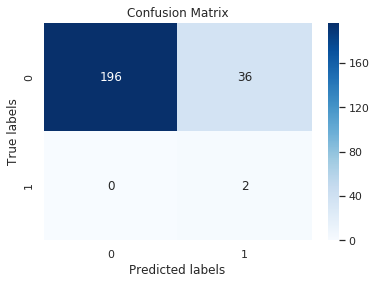

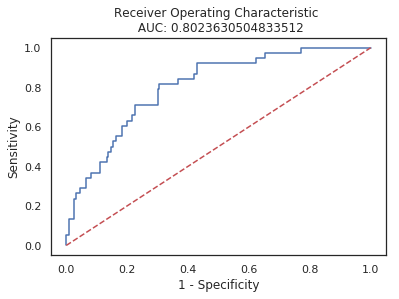

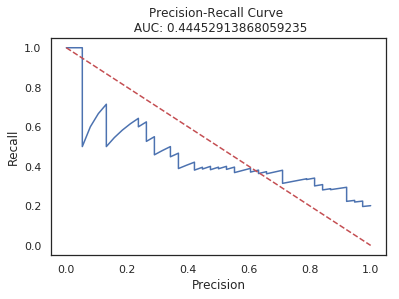

'saved precision recall curve'

In [49]:
get_metrics(probability_sick, actual_labels, threshold)
display_conf_mat(probability_sick, actual_labels, threshold)
get_roc_curve(probability_sick, actual_labels)
get_precision_recall_curve(probability_sick, actual_labels)

## Prediction Visualization

(doesn't work with our multi-model - maybe i'll fix it soon but eh)


In [0]:
def plot_image(i, probability_sick, actual_labels, images_bucket, threshold):
    '''
    Plots images next to labels, color coded based on if they were correct or not.
    '''
    prob_sick = probability_sick[i]
    true_label = int(actual_labels[i])

    # Remove grid, x and y axis ticks from the chart
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Plot the image
    plt.imshow( images_bucket[i, :, :, 0], cmap='gray')

    if prob_sick > threshold:
        predicted_label = 1
    else:
        predicted_label = 0
    
    # Set color to blue on a correct prediction, otherwise set color to red
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names = ['Not '+target, target ]
    # Print the predicted label, confidence number, and actual label
    plot_label = f"Predicted probability of {target} is {round(100*prob_sick, 2)}%, " + \
            f"\n so we predict {class_names[predicted_label]} " + \
            f"\n while true label is {class_names[true_label]}"
    plt.xlabel(plot_label,color=color)

In [0]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols


fig = plt.figure(figsize=(4*2*num_cols, 4*num_rows))
fig.subplots_adjust(hspace=.5)

images_bucket = test_generator[0][0]

for i in range(num_images):
    print(f'Probability of sickness: {round(100* probability_sick[i], 2)}%  Actual label: {int(actual_labels[i])}')
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, probability_sick, actual_labels, images_bucket, threshold)
    
plt.savefig(model_directory+model_name+'sample_predictions.pdf')

NameError: ignored

<Figure size 1728x1152 with 0 Axes>

## Add everything to Google Drive

In [0]:
!cp -r $model_directory '/content/drive/My Drive/The Cool Kids/Gabi/'$model_directory